<a href="https://colab.research.google.com/github/chang-heekim/Implementation_Deep_Learning_Paper/blob/main/Deep%20Convolutional%20Generative%20Adversarial%20Nets/DCGAN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torchvision.utils as vutils
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

# Set up Hyper Parameters

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
lr = 2e-4
beta1  = 0.5
beta2 = 0.999
epochs = 70
image_size = 64
noise_dim = 100

# Load Celeb_A Dataset

In [ ]:
data_root = '/content/img_align_celeba'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(data_root, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)

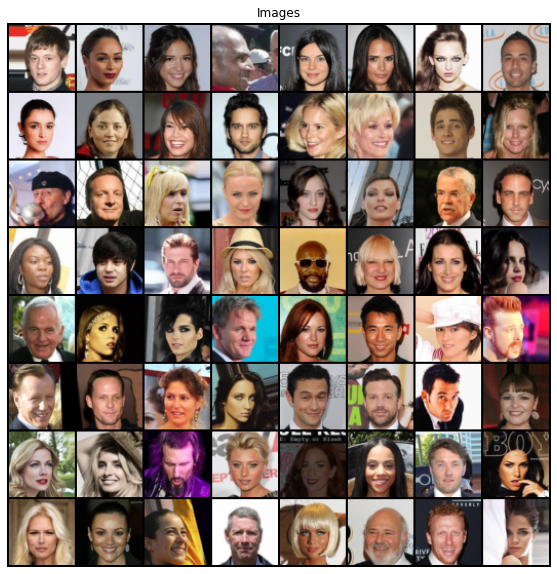

In [ ]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Images')
plt.imshow(np.transpose(vutils.make_grid(images[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Design Discriminator & Generator



In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.gen(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.disc(input).view(-1, 1)

In [ ]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define Discriminator & Generator And Initialize weights

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

discriminator.apply(init_weights)
generator.apply(init_weights)

summary(discriminator, (3, 64, 64))
print()
summary(generator, (noise_dim, 1, 1))

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1 , beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1 , beta2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

# Training

In [ ]:
fake_image_lst = []
real_image_lst = []

for epoch in range(1, epochs + 1):
    for idx, (imgs, _) in enumerate(train_loader):
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

        real_images = imgs.to(device)

        # Training Generator
        optimizer_G.zero_grad()

        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        g_imgs = generator(noise)
        g_loss = criterion(discriminator(g_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        # Training Discriminator
        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(real_images), real)
        fake_loss = criterion(discriminator(g_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
    
        if idx == 0:
            fake_image_lst.append(g_imgs[:5].detach().cpu().numpy())
            real_image_lst.append(real_images[:5].detach().cpu().numpy())
            
    if epoch % 10 == 0:
        save_image(real_images.data[:25], f'{epoch}_real_images.png', nrow=5, normalize=True)
        save_image(g_imgs.data[:25], f'{epoch}_generated.png', nrow=5, normalize=True)

    print(f'[Epoch {epoch} / {epochs}] G Loss: {g_loss.item():.6f} \tD Loss: {d_loss.item():.6f}')

[Epoch 1 / 70] G Loss: 0.942811 	D Loss: 0.479530
[Epoch 2 / 70] G Loss: 0.880487 	D Loss: 0.450760
[Epoch 3 / 70] G Loss: 1.481749 	D Loss: 0.249216
[Epoch 4 / 70] G Loss: 0.930661 	D Loss: 0.401513
[Epoch 5 / 70] G Loss: 3.011545 	D Loss: 0.261621
[Epoch 6 / 70] G Loss: 1.419175 	D Loss: 0.282932
[Epoch 7 / 70] G Loss: 2.659531 	D Loss: 0.295872
[Epoch 8 / 70] G Loss: 1.492619 	D Loss: 0.245075
[Epoch 9 / 70] G Loss: 3.070776 	D Loss: 0.180087
[Epoch 10 / 70] G Loss: 3.126077 	D Loss: 0.162698
[Epoch 11 / 70] G Loss: 2.504419 	D Loss: 0.116574
[Epoch 12 / 70] G Loss: 3.580369 	D Loss: 0.139476
[Epoch 13 / 70] G Loss: 2.911240 	D Loss: 0.118337
[Epoch 14 / 70] G Loss: 2.691845 	D Loss: 0.098523
[Epoch 15 / 70] G Loss: 2.938431 	D Loss: 0.065992
[Epoch 16 / 70] G Loss: 3.171553 	D Loss: 0.065614
[Epoch 17 / 70] G Loss: 3.337467 	D Loss: 0.092880
[Epoch 18 / 70] G Loss: 3.006583 	D Loss: 0.063856
[Epoch 19 / 70] G Loss: 3.625770 	D Loss: 0.091777
[Epoch 20 / 70] G Loss: 1.941498 	D Loss

# Visualization Generated Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


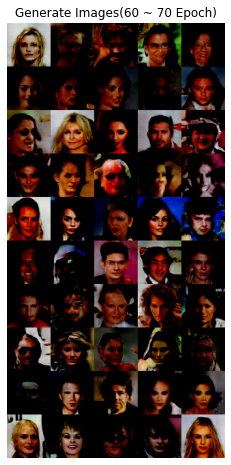

In [ ]:
plt.figure(figsize=(8, 8))
fake_images = []

for image in fake_image_lst[60:70]:
    images = np.transpose(image, (2, 0, 3, 1))
    images = np.reshape(images, (64, -1, 3))
    fake_images.append(images)

fake_images = np.array(fake_images)
plt.imshow(np.concatenate(fake_images, axis=0))
plt.title('Generate Images(60 ~ 70 Epoch)')
plt.axis('off')
plt.show()

# Saving Model

In [ ]:
torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')